                AGE      LOS_DAYS
count  58976.000000  58976.000000
mean      64.429189     10.133916
std       57.198307     12.456682
min        0.000000     -0.945139
25%       43.487337      3.743750
50%       61.756331      6.467014
75%       75.885010     11.795139
max      311.553730    294.660417
DIAGNOSIS
NEWBORN                                                      7823
PNEUMONIA                                                    1566
SEPSIS                                                       1184
CONGESTIVE HEART FAILURE                                      928
CORONARY ARTERY DISEASE                                       840
CHEST PAIN                                                    778
INTRACRANIAL HEMORRHAGE                                       713
ALTERED MENTAL STATUS                                         712
GASTROINTESTINAL BLEED                                        686
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA     583
UPPER GI BLEED          

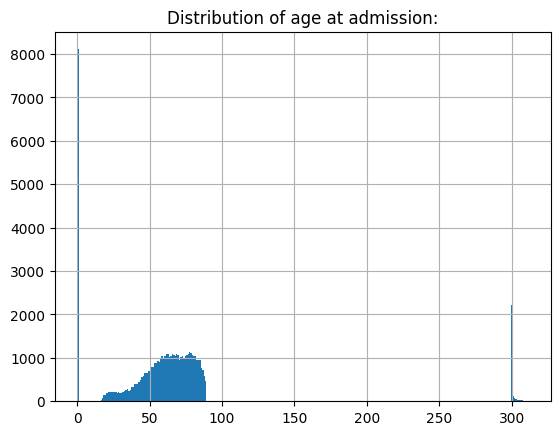

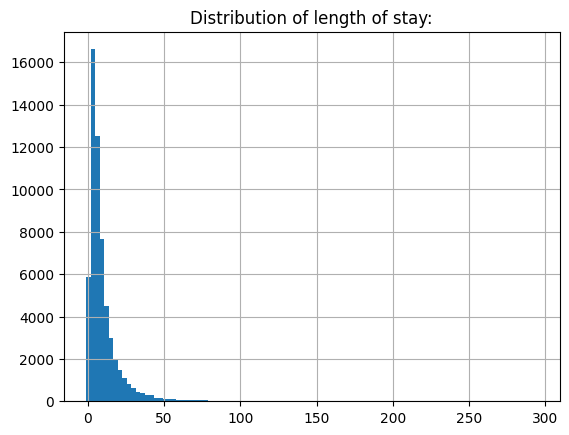

number of admissions that lasted 5 to 14 days: 24773 of total admissions: 58976


In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
def calculate_age(row):
    admit = row['ADMITTIME'].to_pydatetime()
    dob = row['DOB'].to_pydatetime()
    return (admit - dob).days / 365.25

admissions = pd.read_pickle("../data/ADMISSIONS.pkl")
patients = pd.read_pickle("../data/PATIENTS.pkl")
date_cols = ['DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN']
patients[date_cols] = patients[date_cols].apply(pd.to_datetime, errors='coerce')
alive_patients_list = patients[patients['DOD'].isna() & patients['DOD_HOSP'].isna() & patients['DOD_SSN'].isna() & (patients['EXPIRE_FLAG'] != 1)]['SUBJECT_ID'].tolist()
admissions["LOS_DAYS"] = (admissions["DISCHTIME"] - admissions["ADMITTIME"]).dt.total_seconds() / (24 * 3600)
admissions.loc[:,'IS_ALIVE'] = admissions['SUBJECT_ID'].isin(alive_patients_list)
subject_id_to_dob = {i:j for (i,j) in zip(patients["SUBJECT_ID"], patients["DOB"])}
admissions['DOB'] = admissions['SUBJECT_ID'].map(subject_id_to_dob)
admissions['AGE'] = admissions.apply(calculate_age, axis=1)

print(admissions[['AGE','LOS_DAYS','IS_ALIVE']].describe())
print(admissions['DIAGNOSIS'].value_counts().head(20))
hadm_id_to_los_days = {i:j for (i,j) in zip(admissions["HADM_ID"], admissions["LOS_DAYS"])}
hadm_id_to_age = {i:j for (i,j) in zip(admissions["HADM_ID"], admissions["AGE"])}
hadm_to_is_alive = {i:j for (i,j) in zip(admissions["HADM_ID"], admissions["IS_ALIVE"])}


plt.figure()
plt.title("Distribution of age at admission:")
admissions['AGE'].hist(bins=311)
plt.show()

plt.figure()
plt.title("Distribution of length of stay:")
admissions['LOS_DAYS'].hist(bins=100)
plt.show()

print("number of admissions that lasted 5 to 14 days:", len(admissions[(admissions['LOS_DAYS'] >= 5) & (admissions['LOS_DAYS'] <= 14)]), 'of total admissions:', len(admissions))


In [2]:
import numpy as np
min_perc = np.average([admissions['LOS_DAYS'].rank(ascending=True, method='average', pct=True, numeric_only=True)[i] for i in admissions[admissions['LOS_DAYS']==5].index])
max_perc = np.average([admissions['LOS_DAYS'].rank(ascending=True, method='average', pct=True, numeric_only=True)[i] for i in admissions[admissions['LOS_DAYS']==14].index])
print(f"5 days correspond to percentile: {min_perc*100}, and 14 days correspond to {max_perc*100} percentile")


5 days correspond to percentile: 38.478364080303855, and 14 days correspond to 80.47256511123169 percentile


In [3]:
#Analysing negative length of stay
neg_los = admissions[(admissions.LOS_DAYS < 0)]
neg_los_dead = neg_los[neg_los['IS_ALIVE'] == False]
neg_los_alive = neg_los[neg_los['IS_ALIVE'] == True]
print(neg_los['IS_ALIVE'].value_counts())
print(neg_los_alive[['DIAGNOSIS','DISCHARGE_LOCATION']].value_counts())
# conclusion: most of the negative length of stay is due to patients who died before being discharged, and the rest is due to patients who were discharged before being admitted 

IS_ALIVE
False    85
True     13
Name: count, dtype: int64
DIAGNOSIS                                                                                                 DISCHARGE_LOCATION       
NEWBORN                                                                                                   SHORT TERM HOSPITAL          4
ETOH INTOXICATION                                                                                         HOME                         2
ABDOMINAL PAIN                                                                                            HOME                         1
ALTERED MENTAL STATUS                                                                                     OTHER FACILITY               1
                                                                                                          HOME HEALTH CARE             1
CHEST PAIN;TELEMETRY                                                                                      HOME              

- Load_notes,
- Remove ISERROR,
- Select only Categories ["Nursing", "Nursing/other", "Physician", 'Discharge summary']


In [4]:
notes = pd.read_pickle("../data/NOTEEVENTS.pkl")
notes = notes[notes.ISERROR!=1]
print(notes.CATEGORY.value_counts())
selected_categories = ["Nursing", "Nursing/other"]
notes_selected = notes[notes['CATEGORY'].isin(selected_categories)]


notes_selected_copy = notes_selected.copy()
notes_selected.loc[:,'AGE'] = notes_selected_copy['HADM_ID'].map(hadm_id_to_age)
notes_selected.loc[:,'LOS_DAYS'] = notes_selected_copy['HADM_ID'].map(hadm_id_to_los_days)
notes_selected.loc[:,'IS_ALIVE'] = notes_selected_copy['HADM_ID'].map(hadm_to_is_alive)
notes_selected.loc[:,'SUBJECT_ID'] = notes_selected_copy['HADM_ID'].map(admissions.set_index('HADM_ID')['SUBJECT_ID'])
print(f"number of selected notes in {selected_categories}: {len(notes_selected)}")


CATEGORY
Nursing/other        821258
Radiology            378920
Nursing              220384
Physician            139763
ECG                  138190
Discharge summary     59652
Echo                  34037
Respiratory           31629
Nutrition              9361
General                8144
Rehab Services         5386
Social Work            2603
Case Management         940
Pharmacy                100
Consult                  98
Name: count, dtype: int64
number of selected notes in ['Nursing', 'Nursing/other']: 1041642


/home/asusaiyah/tmp/ipykernel_1569032/188472893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_selected.loc[:,'AGE'] = notes_selected_copy['HADM_ID'].map(hadm_id_to_age)
/home/asusaiyah/tmp/ipykernel_1569032/188472893.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_selected.loc[:,'LOS_DAYS'] = notes_selected_copy['HADM_ID'].map(hadm_id_to_los_days)
/home/asusaiyah/tmp/ipykernel_1569032/188472893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat


Checking if changing report to lower case helps in number of reports to split into sentences

In [5]:
def get_repetition_stats(df,column):
      row_frequency = df[column].value_counts().reset_index(name='frequency')
      repeating_rows = row_frequency[row_frequency['frequency'] > 1]
      unique_rows = row_frequency[row_frequency['frequency'] == 1]
      print(f"""{len(repeating_rows)} rows repeat to make {repeating_rows[repeating_rows['frequency'] > 1]['frequency'].sum()} rows\n
            with an additional {len(unique_rows)} unique rows. This makes a total of {len(df)} rows.""")

notes_selected.loc[:,'TEXT_LOWER'] = notes_selected.copy()['TEXT'].str.lower()
print("TEXT")
get_repetition_stats(notes_selected,'TEXT')
print("TEXT_LOWER")
get_repetition_stats(notes_selected,'TEXT_LOWER')

print(f"CONCLUSION: Just {61558-60253} reports get benefitted from lower case. but caching is can help 2 percent of the reports.")


/home/asusaiyah/tmp/ipykernel_1569032/3857012781.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notes_selected.loc[:,'TEXT_LOWER'] = notes_selected.copy()['TEXT'].str.lower()


TEXT
25431 rows repeat to make 60253 rows

            with an additional 981389 unique rows. This makes a total of 1041642 rows.
TEXT_LOWER
25717 rows repeat to make 61558 rows

            with an additional 980084 unique rows. This makes a total of 1041642 rows.
CONCLUSION: Just 1305 reports get benefitted from lower case. but caching is can help 2 percent of the reports.


- Remove error strings
- Fill abbreviations


In [13]:
import os,sys
import spacy, importlib

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
import utils.nlp_tools as nlp_tools
nlp_tools = importlib.reload(nlp_tools)
# Load the English model (download if you haven't: python -m spacy download en_core_web_lg)
nlp = nlp_tools.TextLib("en_core_web_lg")

from resources.abbreviations import abbreviation_dict

report_counts = 0
def replace_abbreviation_and_print_progress(text):
    global abbreviation_dict, report_counts
    report_counts += 1
    if report_counts % 100000 == 0:
        print(f"Processed {report_counts} reports")
    if text is None:
        return text
    if isinstance(text, str):
        text = nlp.replace_abbreviations(text, abbreviation_dict)
    return text
    
print("Removing error strings")
notes_selected.loc[:,'TEXT'] = notes_selected['TEXT'].apply(lambda x: nlp.remove_error_strings(x))

# print(f"Filling abbreviations on {len(notes_selected)} reports")
# notes_selected.loc[:,'TEXT'] = notes_selected['TEXT'].apply(replace_abbreviation_and_print_progress)

# notes_selected.to_pickle("../data/NOTEEVENTS_NURSINGNOTES_REMOVED_ERROR_STRINGS_FILLED_ABBREVIATIONS.pkl")


Removing error strings


In [14]:
notes_selected = pd.read_pickle("../data/NOTEEVENTS_NURSINGNOTES_REMOVED_ERROR_STRINGS_FILLED_ABBREVIATIONS.pkl")
hadm_to_num_notes = notes_selected.groupby('HADM_ID').size()
max_notes_per_day = (notes_selected.groupby(['HADM_ID', 'CHARTDATE']).size().groupby(level='HADM_ID').max())
maximum_notes_per_chart_time = (notes_selected.groupby(['HADM_ID', 'CHARTTIME']).size().groupby(level='HADM_ID').max())
notes_selected['NUM_NOTES'] = notes_selected['HADM_ID'].map(hadm_to_num_notes)
notes_selected['MAX_NOTES_PER_DAY'] = notes_selected['HADM_ID'].map(max_notes_per_day)
notes_selected['MAX_NOTES_PER_CHARTTIME'] = notes_selected['HADM_ID'].map(maximum_notes_per_chart_time)



LOS_DAYS Quartiles :
Q1 (25th percentile): 9.93
Q2 (Median):          21.83
Q3 (75th percentile): 45.71
Number of rows in this range q1-q3: 260452


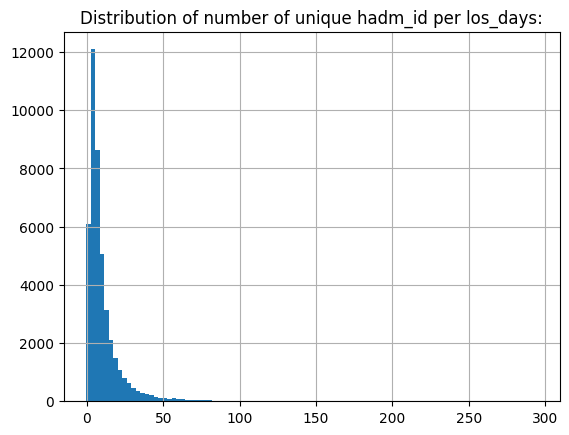

In [15]:
def get_quartiles(df, column):
    """
    Calculate the quartiles (Q1, Q2, Q3) for a given column in a DataFrame and return the quartile values along with the subset of rows between Q1 and Q2.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name for which to calculate quartiles.

    Returns:
        tuple: (q1, q2, q3, mid_df)
            q1 (float): 25th percentile value.
            q2 (float): Median (50th percentile) value.
            q3 (float): 75th percentile value.
            mid_df (pd.DataFrame): Subset of df where column values are between q1 and q2 (inclusive).
    """
    q1 = df[column].quantile(0.25)
    q2 = df[column].median()
    q3 = df[column].quantile(0.75)
    mid_df = df[(df[column]>=q1)&(df[column]<=q2)]
    num = len(mid_df)
    print(f"{column} Quartiles :")
    print(f"Q1 (25th percentile): {q1:.2f}")
    print(f"Q2 (Median):          {q2:.2f}")
    print(f"Q3 (75th percentile): {q3:.2f}")
    print(f"Number of rows in this range q1-q3: {num}")
    return q1,q2,q3,mid_df

# get_quartiles(notes_selected, 'AGE')
get_quartiles(notes_selected, 'LOS_DAYS')
plt.figure()
plt.title("Distribution of number of unique hadm_id per los_days:")
notes_selected[['HADM_ID','LOS_DAYS']].drop_duplicates()['LOS_DAYS'].hist(bins=100)
plt.show()



Filter
- remove all reports with IS_ERROR
- keep only reports from IS_ALIVE admissions
- keep only Nursing/other and Nursing
- Num reports must atleast be number of days of stay
- people age of [18, 89) selected
- Length of stay 5 to 14 days ( No reasoning yet)
choose between:
    - eliminate patients who have atleast two reports with same stortime.
    - max num of reports per day <= 5 (too many reports due to show)


In [16]:

# - remove all reports with IS_ERROR
notes_selected = notes_selected[notes_selected['ISERROR'] != 1]
# - keep only reports from IS_ALIVE admissions
notes_selected = notes_selected[notes_selected['IS_ALIVE'] == True]
# - keep only Nursing/other and Nursing
notes_selected = notes_selected[notes_selected['CATEGORY'].isin(["Nursing", "Nursing/other"])]
# - Num reports must atleast be number of days of stay
notes_selected = notes_selected[notes_selected['NUM_NOTES'] >= notes_selected['LOS_DAYS']]
# - people age of [18, 89) selected
notes_selected = notes_selected[(notes_selected['AGE'] >= 18) & (notes_selected['AGE'] < 89)]
# - Length of stay 5 to 14 days 
notes_selected = notes_selected[(notes_selected['LOS_DAYS'] >= 5) & (notes_selected['LOS_DAYS'] <= 14)]
# - max num of reports per day <= 5 (too many reports due to show)
notes_selected = notes_selected[notes_selected['MAX_NOTES_PER_DAY'] <= 5]
# - max num of reports per chart time == 1 (too many reports due to show)
notes_selected = notes_selected[notes_selected['MAX_NOTES_PER_CHARTTIME'] == 1]
len(notes_selected), len(notes_selected['HADM_ID'].unique()), len(notes_selected['SUBJECT_ID'].unique())



(22680, 1835, 1798)

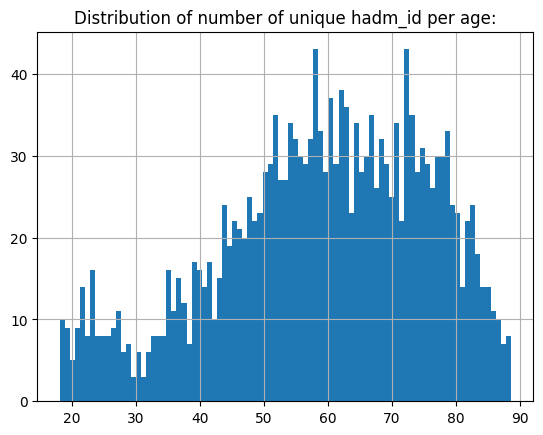

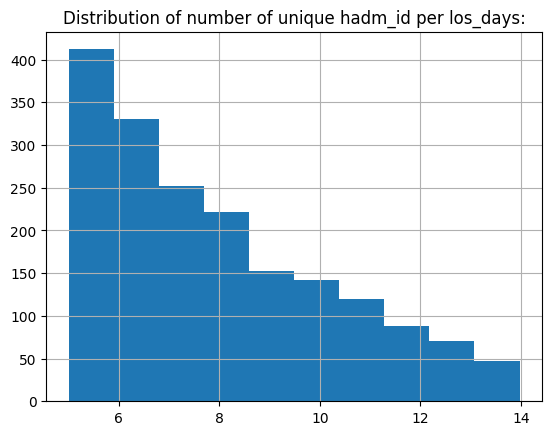

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Distribution of number of unique hadm_id per age:")
notes_selected[['HADM_ID','AGE']].drop_duplicates()['AGE'].hist(bins=89)
plt.savefig("../exports/images/age_distribution.png")
plt.show()

plt.figure()
plt.title("Distribution of number of unique hadm_id per los_days:")
notes_selected[['HADM_ID','LOS_DAYS']].drop_duplicates()['LOS_DAYS'].hist(bins=10)
plt.savefig("../exports/images/los_days_distribution.png")
plt.show()


In [ ]:
max_notes_per_day[199998]

np.int64(2)

Extract sentences from the Report. and Clean the sentences as follows:

- split sentences at ;
- strinp blank leading and training white spaces
- convert to lower case
- strip off trailing periods
- replace double spaces with single spaces


In [ ]:
# def extract_sentences(text):
#     sentences_raw = nlp.sentence_splitter(text,span=False)
#     sentences = [sent['text'] for sent in sentences_raw]
#     return sentences 

# def clean_sentences(list_of_sentences):
#     result_list_of_sentences = []
#     for full_sentence in list_of_sentences:
#         splitted_sentences = full_sentence.split(";")
#         for sentence in splitted_sentences:
#             sentence = sentence.strip().lower().rstrip('.').replace("  "," ")
#             result_list_of_sentences.append(sentence)
#     return result_list_of_sentences



# notes_selected['Sentences'] = [[]]*len(notes_selected)
# print(f"Time to extract sentences from 100 reports: ")
# import time
# start_time = time.time()
# notes_selected.loc[:100,'Sentences'] = notes_selected['TEXT'].iloc[:100].apply(extract_sentences)
# end_time = time.time()
# time_per_100 = end_time - start_time
# print(f"Time taken: {time_per_100} seconds")
# print(f" projected time for {len(notes_selected)} reports: {time_per_100 * (len(notes_selected) / 100) / 60} minutes")
# print("extracting sentences for all reports...")
# notes_selected.loc[:,'Sentences'] = notes_selected['TEXT'].apply(extract_sentences)
# notes_selected['Sentences_Cleaned'] = notes_selected['Sentences'].apply(clean_sentences)

Time to extract sentences from 100 reports: 
Time taken: 5.746875524520874 seconds
 projected time for 22680 reports: 21.723189482688905 minutes
extracting sentences for all reports...


In [ ]:
# notes_selected.to_pickle("../exports/filtered_patient_reports_v2.pkl")

In [ ]:
notes_selected = pd.read_pickle("../exports/filtered_patient_reports_v2.pkl")
notes_selected["Senteces_length"] = notes_selected['Sentences_Cleaned'].apply(lambda x: len(x))
total_sentences = notes_selected['Senteces_length'].sum()
print(f"Total sentences extracted: {total_sentences}")
numberofreports = len(notes_selected)
print(f"Total number of reports: {numberofreports}")
sentences_per_report = notes_selected['Senteces_length'].mean()
print(f"Average number of sentences per report: {sentences_per_report}")
num_patients = notes_selected['HADM_ID'].nunique()
print(f"Total number of patients: {num_patients}")

Total sentences extracted: 567524
Total number of reports: 25248
Average number of sentences per report: 22.47797845373891
Total number of patients: 1964
